In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

%matplotlib inline

In [2]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

In [3]:
path = 'data/ml-10M100K/'  # ML-10M files
train = pd.read_csv(path+'train_predictions.csv')
train['test'] = 0
test = pd.read_csv(path+'holdout_predictions.csv')
test['test'] = 1
df = pd.concat((train, test), ignore_index=True)
df.head()

,movieId,title,Drama,prediction,test
0,3827,"Slipper and the Rose, The (1976)",0,0,0
1,5666,"Journey of Natty Gann, The (1985)",0,0,0
2,1877,"Last Seduction, The (1994)",1,1,0
3,10407,"Wrong Man, The (1993)",0,1,0
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0


In [4]:
df.shape

(10677, 5)

In [5]:
df.Drama.value_counts()

0    5341
1    5336
Name: Drama, dtype: int64

## Load rating data

In [6]:
all_files = glob.glob(os.path.join(path, "ratings*.csv"))
ratings = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [7]:
ratings.head()

,userId,movieId,rating
0,69587,1005,2.0
1,47904,193,4.0
2,26906,3097,3.5
3,31241,559,1.0
4,69402,2541,4.0


In [8]:
ratings.shape

(10000054, 3)

In [9]:
rating_counts = ratings.groupby('movieId').agg({'rating':'count'}).reset_index()
rating_counts.columns = ['movieId', 'n_ratings']
rating_counts.head()

,movieId,n_ratings
0,0,2412
1,1,14975
2,2,17851
3,3,16075
4,4,18925


In [10]:
rating_avgs = ratings.groupby('movieId').agg({'rating':'mean'}).reset_index()
rating_avgs.columns = ['movieId', 'mean_rating']
rating_avgs.head()

,movieId,mean_rating
0,0,2.861318
1,1,3.125209
2,2,2.936950
3,3,3.418414
4,4,3.349353


In [11]:
rating_var = ratings.groupby('movieId').agg({'rating':'std'}).reset_index()
rating_var.columns = ['movieId', 'std_rating']
rating_var.head()

,movieId,std_rating
0,0,0.925773
1,1,0.950148
2,2,1.188031
3,3,0.866052
4,4,0.941355


In [12]:
df = pd.merge(df, rating_counts, how='inner', on='movieId')
df = pd.merge(df, rating_avgs, how='inner', on='movieId')
df = pd.merge(df, rating_var, how='inner', on='movieId')
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518


In [13]:
df['correct'] = (df['Drama'] == df['prediction']).astype('int')
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating,correct
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214,1
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721,1
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974,1
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678,0
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518,1


## 1. Number of ratings per movie

In [14]:
np.arange(0, 101, 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [15]:
bins = list(np.percentile(df.n_ratings.values, np.arange(0, 101, 10)))
labels = list(np.arange(10, 101, 10))
df['n_ratings_percentile'] = pd.cut(df['n_ratings'], bins=bins, labels=labels, include_lowest=True)
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating,correct,n_ratings_percentile
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214,1,50
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721,1,80
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974,1,80
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678,0,10
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518,1,50


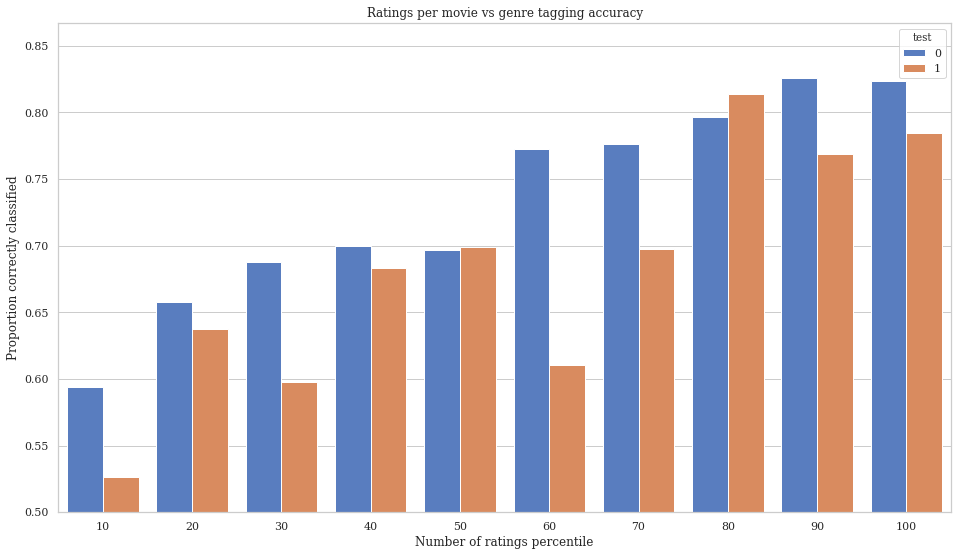

In [16]:
plt_df = df.groupby(['n_ratings_percentile','test'], as_index=False).agg({'correct':'mean'})

g = sns.barplot(x='n_ratings_percentile', y='correct', hue='test', data=plt_df, palette='muted')
g.set(ylim=(.5, None))
plt.ylabel('Proportion correctly classified')
plt.xlabel('Number of ratings percentile')
plt.title('Ratings per movie vs genre tagging accuracy')
plt.show()

In [19]:
df.n_ratings.describe()

count    10677.000000
mean       936.597733
std       2487.328304
min          1.000000
25%         34.000000
50%        135.000000
75%        626.000000
max      34864.000000
Name: n_ratings, dtype: float64

In [20]:
bins = [1,5,10,20,50,100,200,500,1000,5000,10000,35000]
labels = [5,10,20,50,100,200,500,1000,5000,10000,35000]
df['n_ratings_binned'] = pd.cut(df['n_ratings'], bins=bins, labels=labels, include_lowest=True)
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating,correct,n_ratings_percentile,n_ratings_binned
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214,1,50,100
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721,1,80,1000
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974,1,80,1000
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678,0,10,5
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518,1,50,200


In [21]:
df.n_ratings_binned.value_counts().sort_index()

5         596
10        450
20        749
50       1668
100      1317
200      1305
500      1587
1000      974
5000     1561
10000     296
35000     174
Name: n_ratings_binned, dtype: int64

In [25]:
df.groupby(['n_ratings_binned','test'], as_index=False).agg({'correct':'mean', 'movieId':'count'})

,n_ratings_binned,test,correct,movieId
0,5,0,0.597786,542
1,5,1,0.518519,54
2,10,0,0.594059,404
3,10,1,0.543478,46
4,20,0,0.670641,671
5,20,1,0.589744,78
6,50,0,0.682031,1497
7,50,1,0.625731,171
8,100,0,0.691983,1185
9,100,1,0.689394,132


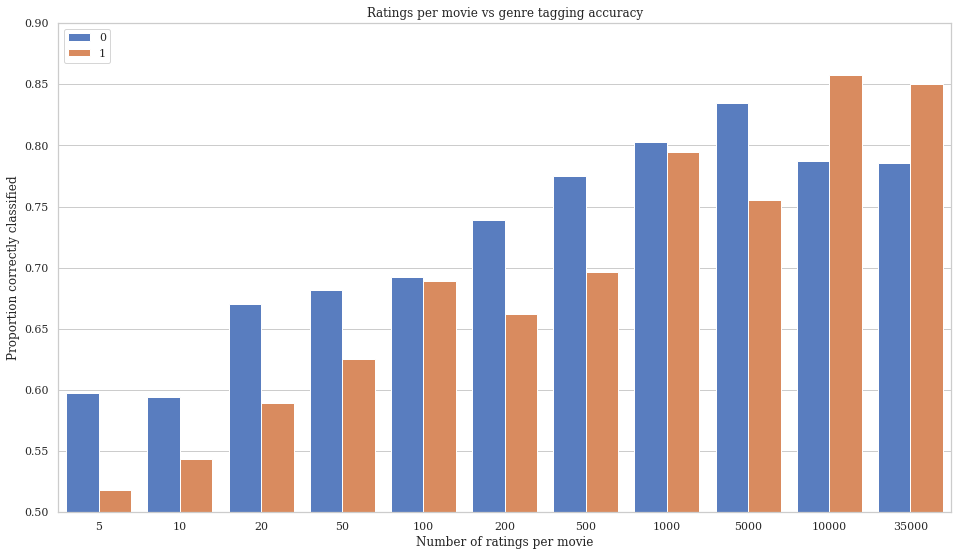

In [24]:
plt_df = df.groupby(['n_ratings_binned','test'], as_index=False).agg({'correct':'mean'})

g = sns.barplot(x='n_ratings_binned', y='correct', hue='test', data=plt_df, palette='muted')
g.set(ylim=(.5, None))
plt.ylabel('Proportion correctly classified')
plt.xlabel('Number of ratings per movie')
plt.title('Ratings per movie vs genre tagging accuracy')
plt.legend(loc='upper left')
plt.show()

## 2. Mean rating

In [19]:
bins = list(np.arange(.5, 5.1, .5))
labels = list(np.arange(1., 5.1, .5))
df['mean_rating_binned'] = pd.cut(df['mean_rating'], bins=bins, labels=labels, include_lowest=True)
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating,correct,n_ratings_percentile,n_ratings_binned,mean_rating_binned
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214,1,50,100,3.5
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721,1,80,1000,4.0
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974,1,80,1000,4.0
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678,0,10,5,3.0
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518,1,50,200,3.0


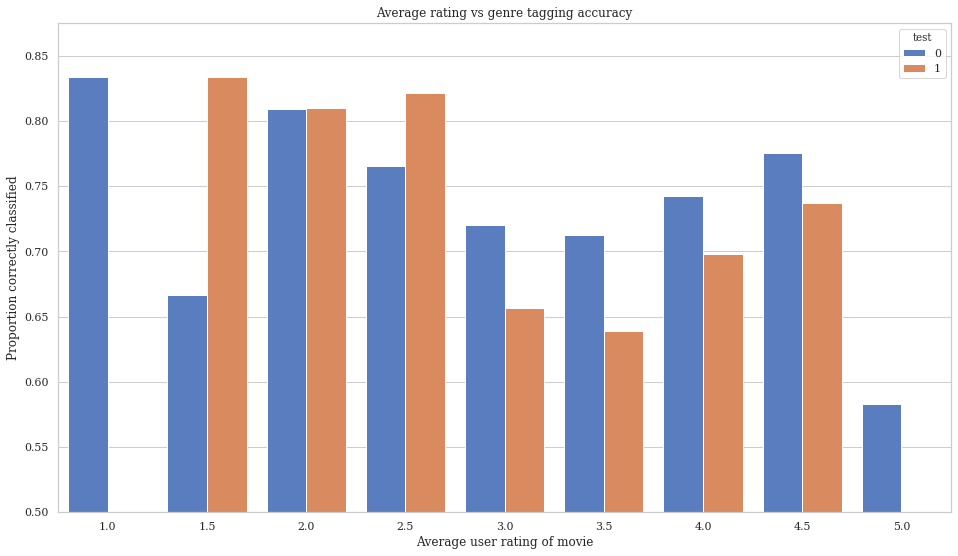

In [20]:
plt_df = df.groupby(['mean_rating_binned','test'], as_index=False).agg({'correct':'mean'})

g = sns.barplot(x='mean_rating_binned', y='correct', hue='test', data=plt_df, palette='muted')
g.set(ylim=(.5, None))
plt.ylabel('Proportion correctly classified')
plt.xlabel('Average user rating of movie')
plt.title('Average rating vs genre tagging accuracy')
plt.show()

## 3. Standard deviation of ratings

In [21]:
df.std_rating.describe()

count    10577.000000
mean         0.955582
std          0.197177
min          0.000000
25%          0.850892
50%          0.951140
75%          1.062061
max          2.474874
Name: std_rating, dtype: float64

In [22]:
bins = [0, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
labels = [.25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
df['std_rating_binned'] = pd.cut(df['std_rating'], bins=bins, labels=labels, include_lowest=True)
df.head()

,movieId,title,Drama,prediction,test,n_ratings,mean_rating,std_rating,correct,n_ratings_percentile,n_ratings_binned,mean_rating_binned,std_rating_binned
0,3827,"Slipper and the Rose, The (1976)",0,0,0,95,3.363158,1.247214,1,50,100,3.5,1.25
1,5666,"Journey of Natty Gann, The (1985)",0,0,0,659,3.531108,0.875721,1,80,1000,4.0,1.00
2,1877,"Last Seduction, The (1994)",1,1,0,546,3.771978,0.841974,1,80,1000,4.0,1.00
3,10407,"Wrong Man, The (1993)",0,1,0,4,2.625000,1.108678,0,10,5,3.0,1.25
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0,0,121,2.504132,0.936518,1,50,200,3.0,1.00


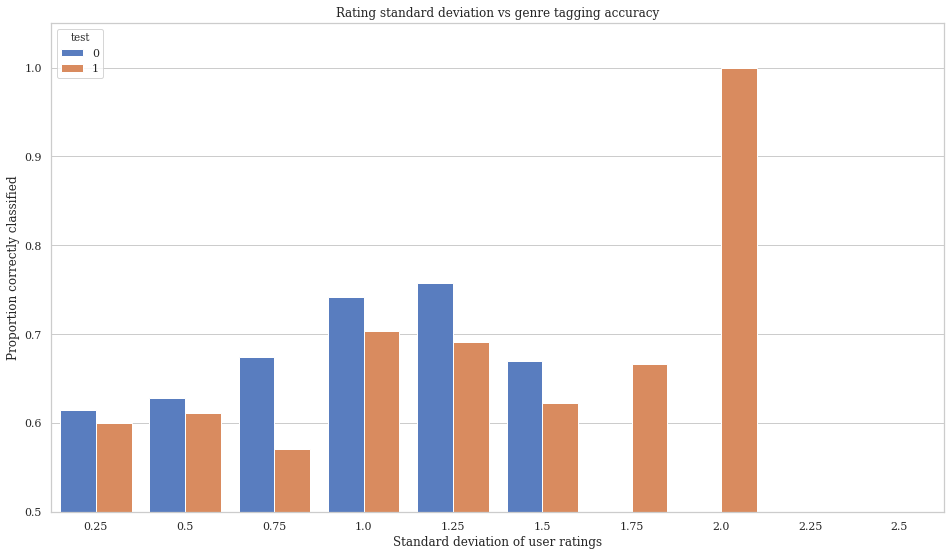

In [30]:
plt_df = df.groupby(['std_rating_binned', 'test']).agg({'correct':'mean'}).reset_index()

g = sns.barplot(x='std_rating_binned', y='correct', hue='test', data=plt_df, palette='muted')
g.set(ylim=(.5, None))
plt.ylabel('Proportion correctly classified')
plt.xlabel('Standard deviation of user ratings')
plt.title('Rating standard deviation vs genre tagging accuracy')
plt.show()